In [2]:
import jieba
jieba.set_dictionary('ChineseDictionary/dict.txt.big')
import numpy as np
import pandas as pd
import operator
import matplotlib.pyplot as plt
%matplotlib inline
data = pd.read_excel("customer_record_data.xlsx")

In [3]:
data.head()

,類別,Unique ID,資料日期,客戶事件描述
0,Call Out,AA2765,20180102 141000,[ECP] 去電確認開戶文件 客戶說後來去買美元保單就不開戶了
1,Call Out,AA3910,20180102 144300,[ECP]不方說 IPO MAIL
2,Call Out,AA3167,20180102 154500,[ECP] IPO 忙 先MAIL
3,Call Out,AA2355,20180102 194359,家庭戶 媽媽說女兒不開了，因為打工收入不穩定
4,Call Out,AA2778,20180103 111132,推Q1


## Unique IDs:

In [4]:
data = np.array(data)
unique_ids = set(data[:,1])
print("Amount of Unique IDs: "+str(len(unique_ids)))

Amount of Unique IDs: 572


## Call times:

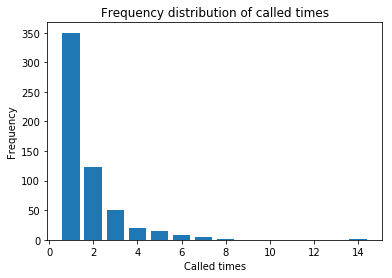

In [5]:
unique_id_called = dict()
for i in data:
    if i[1] in unique_id_called:
        unique_id_called[i[1]] += 1
    else:
        unique_id_called[i[1]] = 1

sorted_unique_id_called = sorted(unique_id_called.items(),key=operator.itemgetter(1))
# for i in range(1,len(unique_id_called)):
#     print(sorted_unique_id_called[-i])

draw_hist = dict()
for i in sorted_unique_id_called:
    if i[1] in draw_hist:
        draw_hist[i[1]] += 1
    else:
        draw_hist[i[1]] = 1
        
keys = np.array(list(draw_hist.keys()))
values = np.array(list(draw_hist.values( ) ) )

plt.bar(keys,values)
plt.title('Frequency distribution of called times')
plt.xlabel('Called times')
plt.ylabel('Frequency')
plt.show()

From the bar chart above we can see that the called time is extremely skewed. Specifically, most customers they reached out have a call time less than 3 times.

## Common word in message

In [6]:
import jieba.analyse
jieba.enable_parallel(8)
cnt = 0
for i in data:
    cnt = cnt + 1
    if cnt <= 15:
        print(jieba.lcut(i[3]))

Building prefix dict from /home/jupyter/DS/DataScience/HW1/ChineseDictionary/dict.txt.big ...
Loading model from cache /tmp/jieba.u42f68d9ace05fa3d7ff1d69de828036b.cache
Loading model cost 1.569 seconds.
Prefix dict has been built succesfully.


['[', 'ECP', ']', ' ', '去電', '確認', '開戶', '文件', ' ', '客戶', '說', '後來', '去', '買', '美元', '保單', '就', '不', '開戶', '了']
['[', 'ECP', ']', '不方', '說', ' ', ' ', 'IPO', ' ', 'MAIL']
['[', 'ECP', ']', ' ', 'IPO', ' ', '忙', ' ', '先', 'MAIL']
['家庭', '戶', ' ', '媽媽', '說', '女兒', '不開', '了', '，', '因為', '打工', '收入', '不', '穩定']
['推', 'Q1']
['兒子', '要', '開戶', '未成年', ',', '不願辦', '網路', '要', '單筆', '買', '亞太', '複合', '債', '.']
['林', 'O', '屏', '216022', ' ', '家庭', '戶', ' ', '有', '可能', '有', '這戶', '下單', '又', '嫌', '麻煩']
['台幣', ' ', '瑞興', ' ', '轉介', '208']
['想', '買', '基金', ' ', '推', 'EC', ' ', '轉介', '之']
['某', '小姐', '要', '買', 'nnl', '新興', '市場', '債', ' ', '美元', '買', ' ']
['[', 'ECP', ']', '可能', '買回', ' ', ' ', '積', ' ', '單', ' ', '可以', '忍', '波動']
['Idris', '轉介']
['客戶', '來電', '說', '看到', '4', '年', 'IPO', ' ', '要', '美金', '的', ' ', '先寄', '開戶', '文件']
['去電', '確認', '外幣', '帳號', '是', '台北', '富邦']
['要', '用', '女兒', '名字', '開']


From the above we can see what is segmented. It is apparently some kind of junk. SO, instead, we search for keywords.

I want to clarify some of the **jieba** feature in the following, there are some different kinds of cutting method.
* cut
* lcut
* cut_for_search
* analyse.extract_tags:
    * This is for extracting keywords by TF-IDF algorithm

In [7]:
key_words = dict()
cnt = 0
for i in data:
    for j in jieba.analyse.extract_tags(i[3]):
        if j in key_words:
            key_words[j] += 1
        else:
            key_words[j] = 1
    cnt = cnt + 1
    if cnt <=15:
        print(jieba.analyse.extract_tags(i[3]))

key_words = sorted(key_words.items(),key=operator.itemgetter(1))

['開戶', '客戶', 'ECP', '去電', '保單', '確認', '後來', '文件', '美元']
['ECP', '不方', 'MAIL', 'IPO']
['ECP', 'MAIL', 'IPO']
['女兒', '媽媽', '因為', '不開', '穩定', '打工', '家庭', '收入']
['Q1']
['不願辦', '單筆', '網路', '開戶', '複合', '兒子', '亞太', '未成年']
['216022', '下單', '麻煩', '這戶', '家庭', '可能']
['瑞興', '台幣', '208', '轉介']
['EC', '轉介', '基金']
['市場', 'nnl', '新興', '小姐', '美元']
['ECP', '波動', '買回', '可能', '可以']
['轉介', 'Idris']
['先寄', '客戶', '開戶', 'IPO', '來電', '美金', '文件', '看到']
['外幣', '去電', '確認', '富邦', '帳號', '台北']
['女兒', '名字']


Now the above seems much more readable, although we may lose some of the information in the cutting stage. Some first thoughts upon seeing these datas.
1. It is mostly key word oriented and thus many verbs are removed
2. Given that it does mention some commodities, it is still hard to decide its intention.
    * For example, '覺得', '計價', '6%', '收益', '美金', '短期', '全球' we don't know whether the customer wants to long or short 美金.
3. There are unimportant verbs concerning selling commodities.
    * 解釋, '收到', '請客'
4. Abbreviations:
    * 國世銀 $\rightarrow$ 國泰世華銀行 ，富邦$\rightarrow$ 富邦銀行
    
The following blocks will show the most commonly appeared word in the service record.

In [8]:
for i in range(1,20):
    
    print(key_words[-i])

    
len(key_words)

('ECP', 441)
('名單', 180)
('開戶', 163)
('Money', 148)
('客戶', 122)
('專刊', 92)
('退休', 84)
('訂閱', 78)
('電子報', 78)
('寄送', 76)
('追蹤', 74)
('分配', 65)
('IPO', 65)
('EC', 62)
('轉介', 59)
('寄回', 57)
('家庭', 54)
('收到', 47)
('表單', 46)


1625

The above method doesn't seems to be a good idea. Since, applying key word count to different customer is useless.
Lets look at what each customer is most interested in. Here we set a limit that a **regular** customer are those who at least called $3$ times.

In [9]:
regular_customer = []
regular_thresh = 3 # Change the number to define what the lower limit should be.
for i in unique_id_called:
    if unique_id_called[i] >= regular_thresh:
#         print("hit")
#         print(unique_id_called[i])
        regular_customer.append(i)
regular_customer = np.array(regular_customer)

df1 = pd.DataFrame([x for x in unique_id_called if unique_id_called[x]>= regular_thresh],columns=['Customer ID'])
df2 = pd.DataFrame([unique_id_called[x] for x in unique_id_called if unique_id_called[x]>= regular_thresh],columns=['Call time'])
df3 = pd.DataFrame(list("abc"),columns=['tags'])
merged_df = pd.concat([df1,df2,df3],axis=1)

cnt = 0
print_limt = 15 # update this to print more customers

for i in regular_customer:
    tag = list()
    # go through the data and find all those that matches "i"
    for j in data:
        if j[1] == i:
            # Change the method of cutting here.
            # I am using keyword search right now, which maybe somehow inaccurate considering the given data.
            tag.append(jieba.analyse.extract_tags( j[3]))
    
    
    tag = [item for sublist in tag for item in sublist]
    merged_df["tags"][cnt] = tag
    cnt += 1
merged_df.head(n=15)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Customer ID,Call time,tags
0,AA2688,3,"[請客, 中國, 開戶, 寄回, follow, ECP, follow, ECP, 沒空,..."
1,AA3052,3,"[基富通, 機會, RSP, LINE, 環球, 好友, ECP, 單筆, 通下, 中國, ..."
2,AA2764,4,"[A200953, EC, 追蹤, 開戶, 再重, 表格, 丈夫, 客戶, 填寫, pass..."
3,AA3594,3,"[推金債, 債有配, 亞債, 金債, ECP, 開戶, 亞債, 考量, 市場, ECP, 太..."
4,AA3367,4,"[名單, 客在, 華南, 私房錢, Money, 580, 要存, 農會, 上班, 分配, ..."
5,AA7534,4,"[10, 名單, 潛在, 點撥, 手機, A174660, 客戶, 52, 九月, 本人, ..."
6,AA3678,3,"[抵到, 天達, 客戶, 單筆, 50, 說明, 黃金, 0.2%, 超過, vip, 國世..."
7,AA3732,3,"[安本, 優惠, 網路, 另想, 客戶, 贖回, 功能, 交易, 小額, 客戶, EC, 買..."
8,AA3596,5,"[金債, 機會, ipo, 商刊, edm, PASS, 先寄, 客戶, ECP, 表單, ..."
9,AA2904,5,"[PASS, 260215, 來電, 戶號, 小姐, 開戶, 260215, 小姐, 朋友,..."


The above shows how the merged dataframe. In the last column, it shows the tags "jieba" has cut off. Also, it is a merged version of all of the appeared tag.

From the free text we have acquired, most of them are already processed. Therefore, I think it is reasonable for us to focus on those which is close to a real sentence. If we can have a **sentence** it would be ideal for us to extract more information out of it. Given the fragment keyword in some users response, we really cannot have much insight.

# Further Improvement
However, for those at least sentence-like ( Still, I need to find some kind of rule to pick those **sentence** out) reponses. I can conduct more elaborate analysis, such as TF-IDF,sentiment analysis... etc.

In [10]:
tag = np.array(data[:,3])
focus = []
cnt = 0
for i in tag:
    if ',' in i:
        focus.append(i)
    elif '推'in i:
        focus.append(i)
    elif len(i) > 15:
        focus.append(i)

for i in range(10):
    print(focus[i])

print("**********length of focus: "+ str(len(focus)))

[ECP] 去電確認開戶文件 客戶說後來去買美元保單就不開戶了
[ECP]不方說  IPO MAIL
[ECP] IPO 忙 先MAIL
家庭戶 媽媽說女兒不開了，因為打工收入不穩定
推Q1
兒子要開戶未成年,不願辦網路要單筆買亞太複合債.
林O屏216022 家庭戶 有可能有這戶下單又嫌麻煩
想買基金 推EC 轉介之
某小姐要買nnl新興市場債 美元買 
[ECP]可能買回  積 單 可以忍波動
**********length of focus: 720


After thinking through how I should deal with **proper** free text, I think a better way is to first find out what text is qualified as free text. From there, can we move on. 

## Making a relation (adjacent) matrix

This section I will make a matrix showing each keywords' relation with one another in a observation(response). 

In [62]:
len(data[:,3])
distinct = set()
for i in range(len(data[:,3])):
    extract = data[i,3]
    for j in jieba.analyse.extract_tags(extract):
        distinct.add(j)

len(distinct)
distinct = list(distinct)
relation = np.zeros([len(distinct),len(distinct)],dtype = int)
for i in range(len(data[:,3])):
    extract = data[i,3]
    extract = jieba.analyse.extract_tags(extract)
    for j in range(len(extract)):
        piv = distinct.index(extract[j])
#         print(piv)
        for k in range(len(extract)):
            if extract[k] == extract[j]:
                continue
            relation[distinct.index(extract[k]),piv] += 1

node_SIZES = []
for i in range(len(distinct)):
    node_SIZES.append(sum(relation[:,i]))
import math
for i in range(len(distinct)):
    for j in range(len(distinct)):
        if relation[i,j]!= 0:
            relation[i,j] = math.pow(1.2,relation[i,j])
#         print(relation[distinct.index(extract[k]),piv])


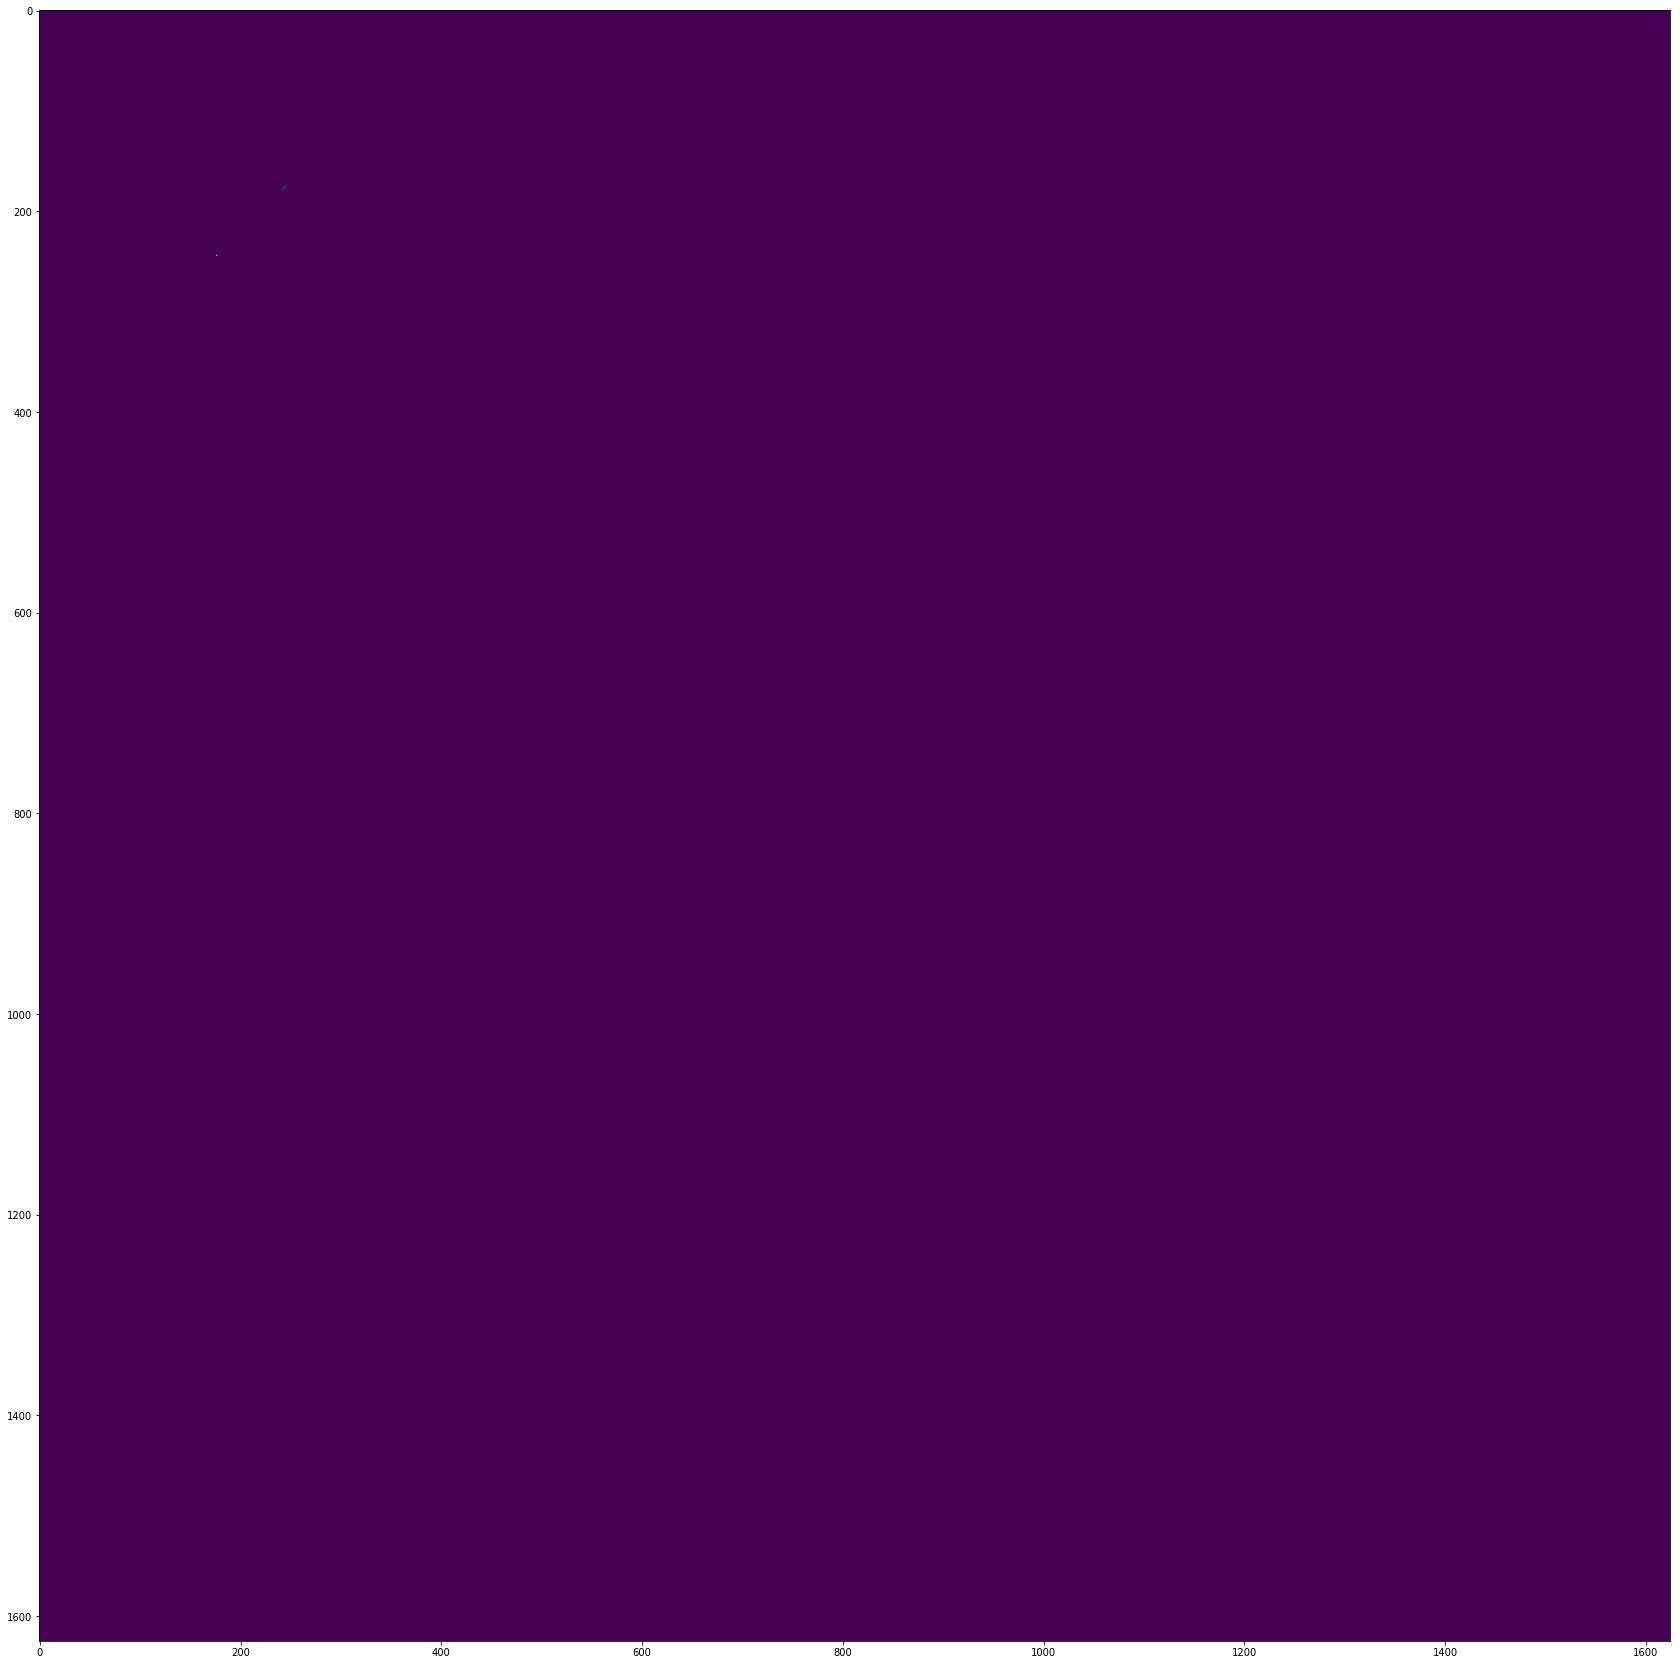

In [69]:
from matplotlib.pyplot import figure
fig, ax = plt.subplots(figsize=(30,30))
im = ax.imshow(relation)
plt.show()

From the above heatmap matrix, we can **barely** see those highlights. I didn't change the label of *x and y* axis because it would simply be unreadable for cramming 16xx entries in such space. Currently, I am not explicitly defining any word that is important to the matrix, so the matrix could include some entries like **確認，轉介**. These items are unwanted, what we want are some financial terms such as **保單，債券，匯率**. 


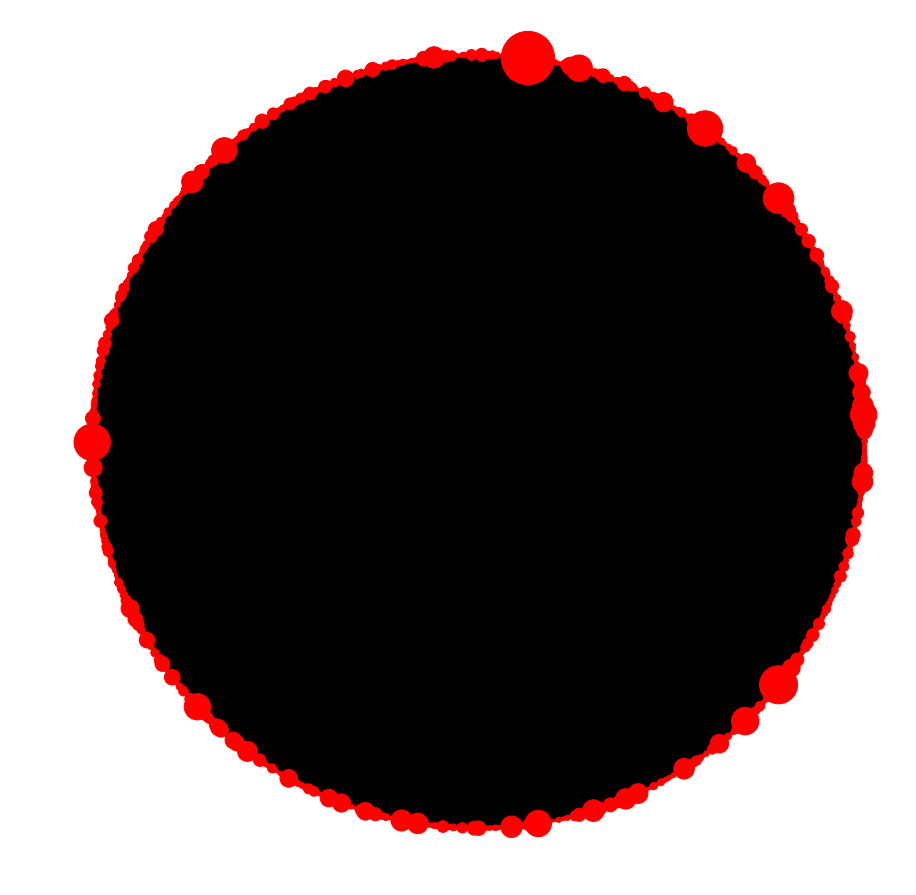

In [65]:
import networkx as nx



G = nx.from_numpy_matrix(relation)
G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),distinct)))    
plt.figure(1,figsize=(12,12)) 

labels = {}
for idx, node in enumerate(G.nodes()):
    labels[node] = ascii_lowercase[idx]

nx.draw_circular(G, node_size=node_SIZES)
plt.show()


This kind of give us an idea that there are some **words** highly mentioned. As some words in the above graph are enlarged. The reason I didnt put the labels on, is that it will be a mess to do so. Moreover, it is a sparsely connected matrix. That is, we may need to reform the matrix into some 


## Conclusion
From the above exploratory, we actually havn't got ourselves anywhere. There are some potential problems to be conquered if further research is to be made.
* Unwanted keyword, but important
    * 贖回...


In [68]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1625
Number of edges: 25233
Average degree:  31.0560
